In [8]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [9]:
from yahoofinancials import YahooFinancials

In [10]:
import datetime as dt

In [11]:
def retrieve_stock_data(ticker, start, end):
    json = YahooFinancials(ticker).get_historical_price_data(start, end, "daily")
    df = pd.DataFrame(columns=["open","close","adjclose"])
    for row in json[ticker]["prices"]:
        date = datetime.fromisoformat(row["formatted_date"])
        df.loc[date] = [row["open"], row["close"], row["adjclose"]]
    df.index.name = "date"
    return df

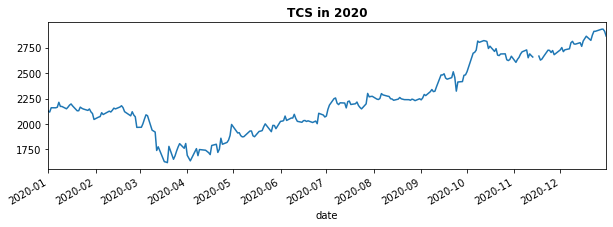

In [16]:
TCS = retrieve_stock_data("TCS.NS", "2020-01-01", "2021-1-1")
fig = plt.figure()
fig.set_size_inches(10,3)
TCS["adjclose"].plot()
plt.title("TCS in 2020", weight="bold");

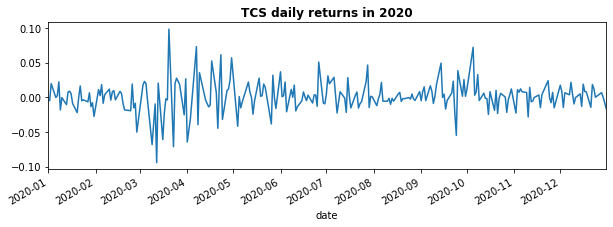

In [17]:
fig = plt.figure()
fig.set_size_inches(10,3)
TCS["adjclose"].pct_change().plot()
plt.title("TCS daily returns in 2020", weight="bold");

0.02204637035020851

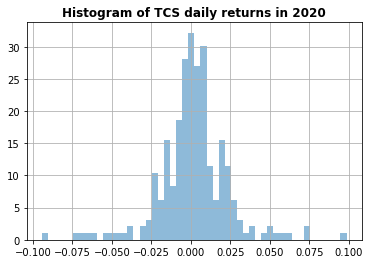

In [18]:
TCS["adjclose"].pct_change().hist(bins=50, density=True, histtype="stepfilled", alpha=0.5)
plt.title("Histogram of TCS daily returns in 2020", weight="bold")
TCS["adjclose"].pct_change().std()

In [32]:
returns = TCS["adjclose"].pct_change().dropna()
mean = returns.mean()
sigma = returns.std()
returns.head(),returns.tail(),mean,sigma

(date
 2020-01-02   -0.004591
 2020-01-03    0.019929
 2020-01-06   -0.000091
 2020-01-07    0.002454
 2020-01-08    0.022395
 Name: adjclose, dtype: float64, date
 2020-12-24    0.000206
 2020-12-28    0.006892
 2020-12-29    0.000376
 2020-12-30   -0.007234
 2020-12-31   -0.016000
 Name: adjclose, dtype: float64, 0.0014315217115607303, 0.02204637035020851)

### Historical Simulation

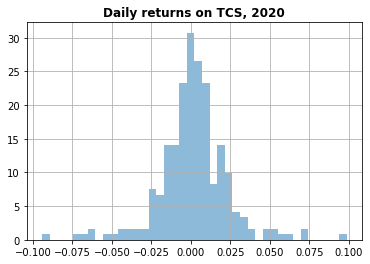

In [20]:
tdf, tmean, tsigma = scipy.stats.t.fit(returns)
returns.hist(bins=40, density=True, histtype="stepfilled", alpha=0.5)
plt.title("Daily returns on TCS, 2020", weight="bold");

### 95% Confidence

In [21]:
returns.quantile(0.05)

-0.030189795662825404

### 99% Confidence

In [22]:
returns.quantile(0.01)

-0.06621239545689683

### Variance-Covariance Method

In [23]:
support = np.linspace(returns.min(), returns.max(), 100)

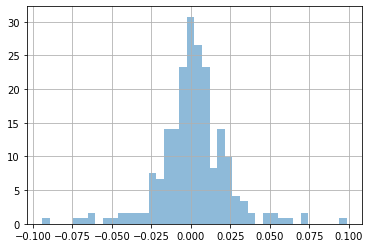

In [17]:
returns.hist(bins=40, density=True, histtype="stepfilled", alpha=0.5)

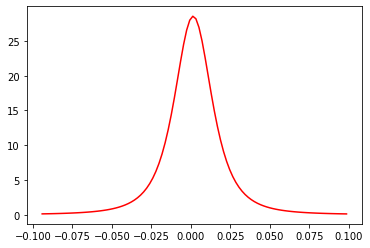

In [18]:
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")

Text(0.5, 1.0, 'Daily change in TCS, 2020 (%)')

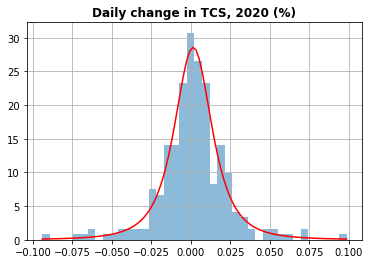

In [24]:
returns.hist(bins=40, density=True, histtype="stepfilled", alpha=0.5)
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.title("Daily change in TCS, 2020 (%)", weight="bold")

### 95% confidence level

In [53]:
scipy.stats.norm.ppf(0.05, mean, sigma)

-0.06436262336649819

### 99% confidence level

In [52]:
scipy.stats.norm.ppf(0.01, mean, sigma)

-0.0916223932500729

### Monte-Carlo Simulations

In [55]:
days = 252
dt = 1/float(days)
sigma = 0.04 # volatility
mu = 0.05  # drift (average growth rate)

In [56]:
def random_walk(startprice):
    price = np.zeros(days)
    shock = np.zeros(days)
    price[0] = startprice
    for i in range(1, days):
        shock[i] = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        price[i] = max(0, price[i-1] + shock[i] * price[i-1])
    return price

### simulating stock prices for a duration of 252 days, starting at the price of 1st Jan 2020


In [38]:
TCS.head()

,open,close,adjclose
date,,,
2020-01-01,2168.000000,2167.600098,2126.850586
2020-01-02,2179.949951,2157.649902,2117.087158
2020-01-03,2164.000000,2200.649902,2159.278564
2020-01-06,2205.000000,2200.449951,2159.082520
2020-01-07,2200.500000,2205.850098,2164.381104


Text(0.5, 1.0, 'Simulated stock prices of TCS for 252 days starting from 1st Jan 2020')

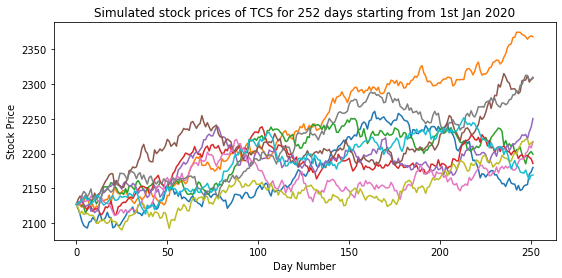

In [42]:
plt.figure(figsize=(9,4))    
for run in range(10):
    plt.plot(random_walk(2126.85))
plt.xlabel("Day Number")
plt.ylabel("Stock Price")
plt.title("Simulated stock prices of TCS for 252 days starting from 1st Jan 2020")

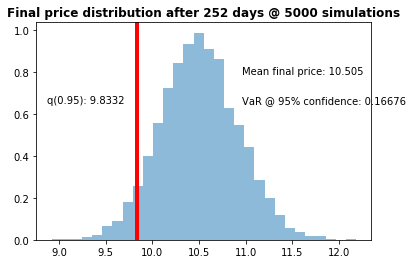

In [57]:
runs = 5000
simulations = np.zeros(runs)
for run in range(runs):
    simulations[run] = random_walk(10)[days-1]
q = np.percentile(simulations, 5)
plt.hist(simulations, density=True, bins=30, histtype="stepfilled", alpha=0.5)
plt.figtext(0.6, 0.7, "Mean final price: {:.5}".format(simulations.mean()))
plt.figtext(0.6, 0.6, "VaR @ 95% confidence: {:.5}".format(10 - q))
plt.figtext(0.15, 0.6, "q(0.95): {:.5}".format(q))
plt.axvline(x=q, linewidth=4, color="r")
plt.title("Final price distribution after {} days @ 5000 simulations".format(days), weight="bold");

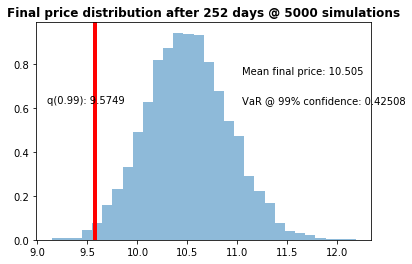

In [58]:
runs = 5000
simulations = np.zeros(runs)
for run in range(runs):
    simulations[run] = random_walk(10)[days-1]
q = np.percentile(simulations, 1)
plt.hist(simulations, density=True, bins=30, histtype="stepfilled", alpha=0.5)
plt.figtext(0.6, 0.7, "Mean final price: {:.5}".format(simulations.mean()))
plt.figtext(0.6, 0.6, "VaR @ 99% confidence: {:.5}".format(10 - q))
plt.figtext(0.15, 0.6, "q(0.99): {:.5}".format(q))
plt.axvline(x=q, linewidth=4, color="r")
plt.title("Final price distribution after {} days @ 5000 simulations".format(days), weight="bold");